# Finding adversarial examples, in depth

Using the same example from the quickstart, we explore how to get more out of the function `find_adversarial_example`

In [1]:
using MIPVerify
using Gurobi
using JuMP
using Images
using Printf

mnist = MIPVerify.read_datasets("MNIST")
n1 = MIPVerify.get_example_network_params("MNIST.n1")
sample_image = MIPVerify.get_image(mnist.test.images, 1);

function print_summary(d::Dict)
    # Helper function to print out output
    obj_val = JuMP.objective_value(d[:Model])
    solve_time = JuMP.solve_time(d[:Model])
    println("Objective Value: $(@sprintf("%.6f", obj_val)), Solve Time: $(@sprintf("%.2f", solve_time))")
end

function view_diff(diff::Array{<:Real, 2})
    n = 1001
    colormap("RdBu", n)[ceil.(Int, (diff .+ 1) ./ 2 .* n)]
end

view_diff (generic function with 1 method)

## `find_adversarial_example`

`find_adversarial_example` takes five positional arguments

```
find_adversarial_example(nn, input, target_selection, optimizer, main_solve_options)
```

It also takes named arguments, each with the default value specified.

```
norm_order = 1
invert_target_selection = false
pp = MIPVerify.UnrestrictedPerturbationFamily()
tightening_algorithm = mip
tightening_options: same as main solver, but with output suppressed and a time limit of 20s per solve.
```

See [full documentation here](https://vtjeng.github.io/MIPVerify.jl/dev/finding_adversarial_examples/single_image/#MIPVerify.find_adversarial_example-Tuple{NeuralNet,Array{#s165,N}%20where%20N%20where%20#s165%3C:Real,Union{Integer,%20Array{#s164,1}%20where%20#s164%3C:Integer},Any,Dict}).

We explore what each of these options allow us to do.

# Basic Options

## Specifying target categories for the adversarial example

`target_selection` and `invert_target_selection` control what the category we want the adversarial example to be classified in.

`target_selection` accepts either a single integer or a list of integers.

For example, if I wanted the original image (which is the digit 7) to be classified as the digit 8 or 9, I could run two separate solves with `target_selection=9` and `target_selection=10` (Julia is 1-indexed), finding closest adversarial examples at an $L_\infty$ distance `0.104073` and `0.046085` ...

In [2]:
d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    9, 
    Gurobi.Optimizer,
    # OutputFlag=0 prevents any output from being printed out
    Dict("OutputFlag" => 0),
    pp = MIPVerify.LInfNormBoundedPerturbationFamily(0.15),
    norm_order = Inf,
    tightening_algorithm = lp,
)
print_summary(d)

Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [9]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only


  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00
  Imposing relu constraint: 100%|███████████████████████| Time: 0:00:00
  Calculating upper bounds:  10%|██▎                    |  ETA: 0:02:50

Academic license - for non-commercial use only


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:19
  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00
  Imposing relu constraint: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Objective Value: 0.104073, Solve Time: 531.95


In [3]:
d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10, 
    Gurobi.Optimizer,
    Dict("OutputFlag" => 0),
    pp = MIPVerify.LInfNormBoundedPerturbationFamily(0.15),
    norm_order = Inf,
    tightening_algorithm = lp,
)
print_summary(d)

Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.


  Calculating upper bounds:  40%|█████████▎             |  ETA: 0:00:00

Academic license - for non-commercial use only
Academic license - for non-commercial use only


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Objective Value: 0.046085, Solve Time: 44.76


Or I can can pass the targets as  `target_selection = [9, 10]`, where the same optimal value of `0.046085` is found.

Solve times for multiple target labels are typically on par with or faster than the aggregate solve times when solving with each target label in sequence.

In [4]:
d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    [9, 10], 
    Gurobi.Optimizer,
    Dict("OutputFlag" => 0),
    pp = MIPVerify.LInfNormBoundedPerturbationFamily(0.15),
    norm_order = Inf,
    tightening_algorithm = lp,
)
print_summary(d)

Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [9, 10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.


  Calculating upper bounds:  10%|██▎                    |  ETA: 0:00:01

Academic license - for non-commercial use only
Academic license - for non-commercial use only


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Objective Value: 0.046085, Solve Time: 24.28


A common use case is to have the adversarial example being in any category but the original:

In [5]:
d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    [1, 2, 3, 4, 5, 6, 7, 9, 10], 
    Gurobi.Optimizer,
    Dict("OutputFlag" => 0),
    pp = MIPVerify.LInfNormBoundedPerturbationFamily(0.15),
    norm_order = Inf,
    tightening_algorithm = lp,
)
print_summary(d)

Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [1, 2, 3, 4, 5, 6, 7, 9, 10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.


  Calculating upper bounds:  25%|█████▊                 |  ETA: 0:00:00

Academic license - for non-commercial use only
Academic license - for non-commercial use only


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Objective Value: 0.046085, Solve Time: 102.45


Rather than typing the full list of other categories, we can set `target_selection = 8`, and `invert_target_selection = true`.

In [6]:
d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    8, 
    Gurobi.Optimizer,
    Dict("OutputFlag" => 0),
    pp = MIPVerify.LInfNormBoundedPerturbationFamily(0.15),
    norm_order = Inf,
    tightening_algorithm = lp,
    invert_target_selection = true,
)
print_summary(d)

Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [1, 2, 3, 4, 5, 6, 7, 9, 10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.


  Calculating upper bounds:  25%|█████▊                 |  ETA: 0:00:00

Academic license - for non-commercial use only
Academic license - for non-commercial use only


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Objective Value: 0.046085, Solve Time: 107.32


## Restricting the Family of Perturbations

### Unrestricted Perturbations

By default, every pixel can be modified without bound.

Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.


  Calculating upper bounds:  15%|███▌                   |  ETA: 0:00:01

Academic license - for non-commercial use only
Academic license - for non-commercial use only


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only
 46.896601 seconds (4.36 M allocations: 177.896 MiB)
Objective Value: 0.046085, Solve Time: 44.07


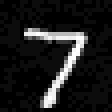

In [7]:
d = @time MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10, 
    Gurobi.Optimizer,
    Dict("OutputFlag" => 0),
    tightening_algorithm = lp,
    norm_order = Inf,
)
print_summary(d)
perturbed_sample_image = value.(d[:PerturbedInput])
colorview(Gray, perturbed_sample_image[1, :, :, 1])

### $L_\infty$-norm Bounded Perturbations

We can bound the $L_\infty$-norm of the perturbation.

As long as the size of the $L_\infty$-norm bound we choose is larger than the actual ($L_\infty$-)minimal perturbation, we will find the same result, and often more quickly.

Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.


  Calculating upper bounds:  25%|█████▊                 |  ETA: 0:00:00

Academic license - for non-commercial use only
Academic license - for non-commercial use only


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only
 41.363017 seconds (2.07 M allocations: 68.034 MiB)


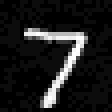

In [8]:
d = @time MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    Gurobi.Optimizer,
    Dict("OutputFlag" => 0),
    tightening_algorithm = lp,
    norm_order=Inf,
)
perturbed_sample_image = value.(d[:PerturbedInput])
colorview(Gray, perturbed_sample_image[1, :, :, 1])

Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only


  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only
 14.070512 seconds (2.93 M allocations: 95.636 MiB)


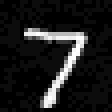

In [9]:
d = @time MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    Gurobi.Optimizer,
    Dict("OutputFlag" => 0),
    tightening_algorithm = lp,
    norm_order=Inf,
    pp = MIPVerify.LInfNormBoundedPerturbationFamily(0.05)
)
perturbed_sample_image = value.(d[:PerturbedInput])
colorview(Gray, perturbed_sample_image[1, :, :, 1])

If the $L_\infty$-norm bound you choose is smaller than the actual minimal perturbation, the problem is infeasible. If you observe the following solve status, there is provably no perturbation within the selected $L_\infty$-norm bound (in this case `0.03`) that is an adversarial example.

In [10]:
d = @time MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    Gurobi.Optimizer,
    Dict("OutputFlag" => 0),
    tightening_algorithm = lp,
    norm_order=Inf,
    pp = MIPVerify.LInfNormBoundedPerturbationFamily(0.03)
)

Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
  0.631356 seconds (2.27 M allocations: 75.066 MiB)


Dict{Any,Any} with 11 entries:
  :TargetIndexes      => [10]
  :SolveTime          => 0.233993
  :TotalTime          => 0.609287
  :Perturbation       => VariableRef[noname noname … noname noname]…
  :PerturbedInput     => VariableRef[noname noname … noname noname]…
  :TighteningApproach => "lp"
  :PerturbationFamily => linf-norm-bounded-0.03
  :SolveStatus        => INFEASIBLE_OR_UNBOUNDED
  :Model              => A JuMP Model…
  :Output             => GenericAffExpr{Float64,VariableRef}[0.0014746447222673…
  :PredictedIndex     => 8

In [11]:
d[:SolveStatus]

INFEASIBLE_OR_UNBOUNDED::TerminationStatusCode = 6

### Blurring Perturbations

We can restrict the perturbations to a blur; in this case, we select a 5x5 kernel. (Note that we are still minimizing over the norm of the perturbation.)

Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.


  Calculating upper bounds:  10%|██▎                    |  ETA: 0:00:01

Academic license - for non-commercial use only
Academic license - for non-commercial use only


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only
 48.396935 seconds (4.98 M allocations: 216.330 MiB, 0.18% gc time)


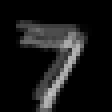

In [12]:
d = @time MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    Gurobi.Optimizer,
    Dict("OutputFlag" => 0),
    tightening_algorithm = lp,
    norm_order=Inf,
    pp = MIPVerify.BlurringPerturbationFamily((5, 5))
)
perturbed_sample_image = value.(d[:PerturbedInput])
colorview(Gray, perturbed_sample_image[1, :, :, 1])

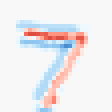

In [13]:
diff = value.(d[:Perturbation])
view_diff(diff[1, :, :, 1])

## Minimizing Over Different Norms
### $L_1$
By default, we minimize the $L_1$ norm of the perturbation. This generally encourages sparsity in the perturbations. 

In this case, the minimum $L_1$ norm perturbation required for the image to be classified as a `9` is `4.641859.`

Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.


  Calculating upper bounds:  10%|██▎                    |  ETA: 0:00:01

Academic license - for non-commercial use only
Academic license - for non-commercial use only


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Objective Value: 4.641859, Solve Time: 55.99


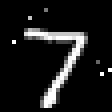

In [14]:
d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    Gurobi.Optimizer,
    Dict("OutputFlag" => 0),
    tightening_algorithm = lp,
    norm_order=1
)
print_summary(d)
perturbed_sample_image = value.(d[:PerturbedInput])
colorview(Gray, perturbed_sample_image[1, :, :, 1])

We also show the difference between the perturbed image and the original image. Red is areas of decreased brightness and blue is areas of increased brightness.

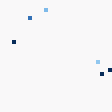

In [15]:
diff = value.(d[:Perturbation])
view_diff(diff[1, :, :, 1])

### $L_\infty$

We can also minimize over the $L_\infty$ norm. This generally results in large patches of the image being changed. 

In this case, the minimum $L_\infty$ norm perturbation required for the image to be classified as a `9` is `0.046085.`

Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.


  Calculating upper bounds:  25%|█████▊                 |  ETA: 0:00:00

Academic license - for non-commercial use only
Academic license - for non-commercial use only


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Objective Value: 0.046085, Solve Time: 42.74


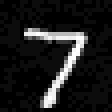

In [16]:
d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    Gurobi.Optimizer,
    Dict("OutputFlag" => 0),
    tightening_algorithm = lp,
    norm_order=Inf
)
print_summary(d)
perturbed_sample_image = value.(d[:PerturbedInput])
colorview(Gray, perturbed_sample_image[1, :, :, 1])

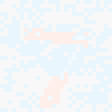

In [17]:
diff = value.(d[:Perturbation])
view_diff(diff[1, :, :, 1])

### $L_2$
With solvers that can handle MIQPs (like Gurobi), we can minimize over the $L_2$ norm. This generally takes a bit more time. 

In this case, the minimum $L_2$ norm perturbation required for the image to be classified as a `9` is `0.705367 = sqrt(0.497542).`

Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.


  Calculating upper bounds:  40%|█████████▎             |  ETA: 0:00:00

Academic license - for non-commercial use only
Academic license - for non-commercial use only


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Objective Value: 0.497542, Solve Time: 815.09


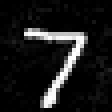

In [18]:
d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    Gurobi.Optimizer,
    Dict("OutputFlag" => 0),
    tightening_algorithm = lp,
    norm_order=2
)
print_summary(d)
perturbed_sample_image = value.(d[:PerturbedInput])
colorview(Gray, perturbed_sample_image[1, :, :, 1])

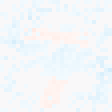

In [19]:
diff = value.(d[:Perturbation])
view_diff(diff[1, :, :, 1])

# Advanced Options

### `tightening_algorithm`

By default, we tighten the bounds on each intermediate value by solving an MIP using the `optimize` with the `tightening_options` specified. Compare total solve times for three different tightening algorithms. As the tightening algorithm gets more complex (`interval_arithmetic -> lp -> mip`), the time spent on tightening bounds increases, but generally (not in this case with `mip`) with a reduction in the amount of time for the main solve. 

You'll have to find the sweet spot for your own application.

In [27]:
@time d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    Gurobi.Optimizer,
    Dict(),
    tightening_algorithm = interval_arithmetic,
    norm_order=Inf
)

Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 1263 rows, 1020 columns and 66888 nonzeros
Model fingerprint: 0xdc39e74c
Variable types: 960 continuous, 60 integer (60 binary)
Coefficient statistics:
  Matrix range     [2e-05, 8e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [5e-01, 4e+02]
  RHS range        [4e-03, 8e+02]
Presolve added 0 rows and 10 columns
Presolve removed 50 rows and 0 columns
Presolve time: 0.07s
Presolved: 1213 rows, 1030 columns, 62933 nonzeros
Variable types: 970 continuous, 60 integer (60 binary)

Root relaxation: objective 

Dict{Any,Any} with 11 entries:
  :TargetIndexes      => [10]
  :SolveTime          => 52.0963
  :TotalTime          => 52.1851
  :Perturbation       => GenericAffExpr{Float64,VariableRef}[noname noname … no…
  :PerturbedInput     => VariableRef[noname noname … noname noname]…
  :TighteningApproach => "interval_arithmetic"
  :PerturbationFamily => unrestricted
  :SolveStatus        => OPTIMAL
  :Model              => A JuMP Model…
  :Output             => GenericAffExpr{Float64,VariableRef}[-0.012063867412507…
  :PredictedIndex     => 8

In [21]:
@time d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    Gurobi.Optimizer,
    Dict(),
    tightening_algorithm = lp,
    norm_order=Inf
)

Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.


  Calculating upper bounds:  35%|████████               |  ETA: 0:00:00

Academic license - for non-commercial use only
Academic license - for non-commercial use only


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 1263 rows, 1020 columns and 66888 nonzeros
Model fingerprint: 0x0202e6a7
Variable types: 960 continuous, 60 integer (60 binary)
Coefficient statistics:
  Matrix range     [2e-05, 7e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [5e-01, 3e+02]
  RHS range        [4e-03, 7e+02]
Presolve added 0 rows and 10 columns
Presolve removed 50 rows and 0 columns
Presolve time: 0.09s
Presolved: 1213 rows, 1030 columns, 62933 nonzeros
Variable types: 970 continuous, 60 integer (60 binary)

Root relaxation: objective 0.000000e+00, 837 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    1          -    0.00000      -     -    0s
H    0     0                       0.4

Dict{Any,Any} with 11 entries:
  :TargetIndexes      => [10]
  :SolveTime          => 42.9934
  :TotalTime          => 43.6904
  :Perturbation       => GenericAffExpr{Float64,VariableRef}[noname noname … no…
  :PerturbedInput     => VariableRef[noname noname … noname noname]…
  :TighteningApproach => "lp"
  :PerturbationFamily => unrestricted
  :SolveStatus        => OPTIMAL
  :Model              => A JuMP Model…
  :Output             => GenericAffExpr{Float64,VariableRef}[-0.012063867412507…
  :PredictedIndex     => 8

In [28]:
@time d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    Gurobi.Optimizer,
    Dict(),
    tightening_algorithm = mip,
    norm_order=Inf
)

Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.


  Calculating upper bounds:  10%|██▎                    |  ETA: 0:00:42

Academic license - for non-commercial use only
Academic license - for non-commercial use only


  Calculating upper bounds: 100%|███████████████████████| Time: 0:02:17
  Calculating lower bounds: 100%|███████████████████████| Time: 0:02:35


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 1263 rows, 1020 columns and 66888 nonzeros
Model fingerprint: 0x04b67a3b
Variable types: 960 continuous, 60 integer (60 binary)
Coefficient statistics:
  Matrix range     [2e-05, 7e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [5e-01, 4e+02]
  RHS range        [4e-03, 7e+02]
Presolve added 0 rows and 10 columns
Presolve removed 50 rows and 0 columns
Presolve time: 0.06s
Presolved: 1213 rows, 1030 columns, 62933 nonzeros
Variable types: 970 continuous, 60 integer (60 binary)

Root relaxation: objective 0.000000e+00, 792 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    4          -    0.00000      -     -    0s
H    0     0                       0.5

Dict{Any,Any} with 11 entries:
  :TargetIndexes      => [10]
  :SolveTime          => 59.1741
  :TotalTime          => 359.826
  :Perturbation       => GenericAffExpr{Float64,VariableRef}[noname noname … no…
  :PerturbedInput     => VariableRef[noname noname … noname noname]…
  :TighteningApproach => "mip"
  :PerturbationFamily => unrestricted
  :SolveStatus        => OPTIMAL
  :Model              => A JuMP Model…
  :Output             => GenericAffExpr{Float64,VariableRef}[-0.012063867412507…
  :PredictedIndex     => 8

We can also modify many of the parameters of the solver to change behavior:

We will be focusing on the parameters available via Gurobi (http://www.gurobi.com/documentation/9.0/refman/parameters.html), but other solvers often have similar options.

  
### `main_solve_options`

#### Muting Output
To mute the output from the `GurobiSolver`, set `OutputFlag=0`.


#### Terminating early if a conditon is satisfied

Sometimes, finding an adversarial example takes a long time:

You may want to terminate early when a particular condition is satisfied. Common reasons are:

  1. Solve exceeding time limit
  2. Lower bound on robustness proved (i.e. `BestBd` increases above a pre-determined threshold)
  3. Counter-example found (i.e. `Incumbent` adversarial image found that is closer to the original image than expected).
  4. Difference between `Incumbent` and `BestBd` falls below a pre-determined threshold.
  
Fortunately, Gurobi has a parameter for all of these cases.

##### Terminate if time limit is reached
Set `TimeLimit`:

In [23]:
@time d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    Gurobi.Optimizer,
    Dict("TimeLimit" => 10),
    tightening_algorithm = lp,
    norm_order=Inf
)

Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.


  Calculating upper bounds:  10%|██▎                    |  ETA: 0:00:01

Academic license - for non-commercial use only
Academic license - for non-commercial use only


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 1263 rows, 1020 columns and 66888 nonzeros
Model fingerprint: 0x0202e6a7
Variable types: 960 continuous, 60 integer (60 binary)
Coefficient statistics:
  Matrix range     [2e-05, 7e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [5e-01, 3e+02]
  RHS range        [4e-03, 7e+02]
Presolve added 0 rows and 10 columns
Presolve removed 50 rows and 0 columns
Presolve time: 0.11s
Presolved: 1213 rows, 1030 columns, 62933 nonzeros
Variable types: 970 continuous, 60 integer (60 binary)

Root relaxation: objective 0.000000e+00, 837 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    1          -    0.00000      -     -    0s
H    0     0                       0.4

Dict{Any,Any} with 11 entries:
  :TargetIndexes      => [10]
  :SolveTime          => 10.0028
  :TotalTime          => 10.8295
  :Perturbation       => GenericAffExpr{Float64,VariableRef}[noname noname … no…
  :PerturbedInput     => VariableRef[noname noname … noname noname]…
  :TighteningApproach => "lp"
  :PerturbationFamily => unrestricted
  :SolveStatus        => TIME_LIMIT
  :Model              => A JuMP Model…
  :Output             => GenericAffExpr{Float64,VariableRef}[-0.012063867412507…
  :PredictedIndex     => 8

##### Terminate if lower bound on robustness proved

Set `BestBdStop`.

In [24]:
@time d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    Gurobi.Optimizer,
    Dict("BestBdStop" => 0.02),
    tightening_algorithm = lp,
    norm_order=Inf
)

Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.


  Calculating upper bounds:  40%|█████████▎             |  ETA: 0:00:00

Academic license - for non-commercial use only
Academic license - for non-commercial use only


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 1263 rows, 1020 columns and 66888 nonzeros
Model fingerprint: 0x0202e6a7
Variable types: 960 continuous, 60 integer (60 binary)
Coefficient statistics:
  Matrix range     [2e-05, 7e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [5e-01, 3e+02]
  RHS range        [4e-03, 7e+02]
Presolve added 0 rows and 10 columns
Presolve removed 50 rows and 0 columns
Presolve time: 0.09s
Presolved: 1213 rows, 1030 columns, 62933 nonzeros
Variable types: 970 continuous, 60 integer (60 binary)

Root relaxation: objective 0.000000e+00, 837 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    1          -    0.00000      -     -    0s
H    0     0                       0.4

Dict{Any,Any} with 11 entries:
  :TargetIndexes      => [10]
  :SolveTime          => 29.3971
  :TotalTime          => 30.2711
  :Perturbation       => GenericAffExpr{Float64,VariableRef}[noname noname … no…
  :PerturbedInput     => VariableRef[noname noname … noname noname]…
  :TighteningApproach => "lp"
  :PerturbationFamily => unrestricted
  :SolveStatus        => OBJECTIVE_LIMIT
  :Model              => A JuMP Model…
  :Output             => GenericAffExpr{Float64,VariableRef}[-0.012063867412507…
  :PredictedIndex     => 8

##### Terminate if adversarial example found closer than expected robustness

Set `BestObjStop`.

In [25]:
@time d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    Gurobi.Optimizer,
    Dict("BestObjStop" => 0.2),
    tightening_algorithm = lp,
    norm_order=Inf
)

Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.


  Calculating upper bounds:  30%|██████▉                |  ETA: 0:00:00

Academic license - for non-commercial use only
Academic license - for non-commercial use only


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 1263 rows, 1020 columns and 66888 nonzeros
Model fingerprint: 0x0202e6a7
Variable types: 960 continuous, 60 integer (60 binary)
Coefficient statistics:
  Matrix range     [2e-05, 7e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [5e-01, 3e+02]
  RHS range        [4e-03, 7e+02]
Presolve added 0 rows and 10 columns
Presolve removed 50 rows and 0 columns
Presolve time: 0.07s
Presolved: 1213 rows, 1030 columns, 62933 nonzeros
Variable types: 970 continuous, 60 integer (60 binary)

Root relaxation: objective 0.000000e+00, 837 iterations, 0.05 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    1          -    0.00000      -     -    0s
H    0     0                       0.4

Dict{Any,Any} with 11 entries:
  :TargetIndexes      => [10]
  :SolveTime          => 11.5785
  :TotalTime          => 12.0981
  :Perturbation       => GenericAffExpr{Float64,VariableRef}[noname noname … no…
  :PerturbedInput     => VariableRef[noname noname … noname noname]…
  :TighteningApproach => "lp"
  :PerturbationFamily => unrestricted
  :SolveStatus        => OBJECTIVE_LIMIT
  :Model              => A JuMP Model…
  :Output             => GenericAffExpr{Float64,VariableRef}[-0.012063867412507…
  :PredictedIndex     => 8

##### Terminate if gap between `Incumbent` and `BestBd` is below threshold

Set `MIPGap`.

In [26]:
@time d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    Gurobi.Optimizer,
    Dict("MIPGap" => 0.4),
    tightening_algorithm = lp,
    norm_order=Inf
)

Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.


  Calculating upper bounds:  20%|████▋                  |  ETA: 0:00:00

Academic license - for non-commercial use only
Academic license - for non-commercial use only


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 1263 rows, 1020 columns and 66888 nonzeros
Model fingerprint: 0x0202e6a7
Variable types: 960 continuous, 60 integer (60 binary)
Coefficient statistics:
  Matrix range     [2e-05, 7e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [5e-01, 3e+02]
  RHS range        [4e-03, 7e+02]
Presolve added 0 rows and 10 columns
Presolve removed 50 rows and 0 columns
Presolve time: 0.09s
Presolved: 1213 rows, 1030 columns, 62933 nonzeros
Variable types: 970 continuous, 60 integer (60 binary)

Root relaxation: objective 0.000000e+00, 837 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    1          -    0.00000      -     -    0s
H    0     0                       0.4

Dict{Any,Any} with 11 entries:
  :TargetIndexes      => [10]
  :SolveTime          => 31.9488
  :TotalTime          => 32.6446
  :Perturbation       => GenericAffExpr{Float64,VariableRef}[noname noname … no…
  :PerturbedInput     => VariableRef[noname noname … noname noname]…
  :TighteningApproach => "lp"
  :PerturbationFamily => unrestricted
  :SolveStatus        => OPTIMAL
  :Model              => A JuMP Model…
  :Output             => GenericAffExpr{Float64,VariableRef}[-0.012063867412507…
  :PredictedIndex     => 8

Whew! That was a lot. The next tutorial will introduce you to everything you can extract from the results dictionary.